# Tensor Decomposition Simuation



By Dongmin Kim

## Data Setups

In [ ]:
import numpy as np
import tensorflow as tf
from keras import models
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Flatten, Dropout
import matplotlib.pyplot as plt
import glob
import sys, os
from contextlib import contextmanager


studentID = 2014311577
np.random.seed(studentID)

Using TensorFlow backend.


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Tensor Decomposition

In [ ]:
!pip install -U tensorly
import matplotlib.pyplot as plt
import tensorly as tl
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import cv2
from skimage.metrics import structural_similarity as ssim
from mpl_toolkits.mplot3d import axes3d
from scipy.misc import face
from scipy.ndimage import zoom
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker
from math import ceil

     |████████████████████████████████| 71kB 2.0MB/s 
     |████████████████████████████████| 163kB 7.7MB/s 
  Created wheel for tensorly: filename=tensorly-0.4.5-cp36-none-any.whl size=100156 sha256=7e9c53309242f4e90cffff067421d6c12273b6e94d0d8b4913deab164ad264a7
  Stored in directory: /root/.cache/pip/wheels/44/ae/02/8d00229a4fd0af192b48d24da903f9975c7ac10e706685fc39
Successfully built tensorly


## Try on Single Image

In [ ]:
class ImageDecomposer():
  def __init__(self, rawimage): # raw image from cv2.read
    print("==INIT IMAGEDECOMPOSER==")
    self.og_tensor = self.to_tensor(rawimage)
    self.cp_tensor = self.to_CP(self.og_tensor)
    self.tk_tensor = self.to_TK(self.og_tensor)
    self.og_image = self.to_image(self.og_tensor)
    self.cp_image = self.to_image(self.cp_tensor)
    self.tk_image = self.to_image(self.tk_tensor)
    print("DONE")

  # original image to tensor  
  def to_tensor(self, image):
    return tl.tensor(zoom(image, (1, 1, 1)), dtype='float64')
  
  # tensor to image
  def to_image(self, tensor):
    im = tl.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)

  # get image difference
  def get_diff_image(self, image1, image2):
    output = lambda x: (x - np.min(x)) / np.max(x) # normalize
    x = np.abs(image1.astype(np.int)-image2.astype(np.int))
    return output(x)

  # tensor decomposition using CP 
  def to_CP(self, tensor, r = 8):
    # Rank of the CP decomposition
    cp_rank = r
    # Perform the CP decomposition
    weights, factors = parafac(tensor, rank=cp_rank, init='random', tol=10e-6)
    # Reconstruct the image from the factors
    cp_reconstruction = tl.kruskal_to_tensor((weights, factors)) 
    return cp_reconstruction

  # tensor decomposition using TK
  def to_TK(self, tensor, r = [100, 100, 3]):
    # Rank of the Tucker decomposition
    tucker_rank = r
    random_state = 42
    # Tucker decomposition
    core, tucker_factors = tucker(tensor, ranks=tucker_rank, init='random', tol=10e-5, random_state=random_state)
    tucker_reconstruction = tl.tucker_to_tensor((core, tucker_factors))
    return tucker_reconstruction

  def plot_CP_panorama(self, colsize = 5, max_rank = 25):
    print("== PLOT CP Panorama ===")
    
    if max_rank % colsize == 0:
      rowsize = max_rank // colsize
    else:
      rowsize = max_rank // colsize + 1

    fig, ax = plt.subplots(rowsize, colsize, sharex='col', sharey='row', figsize = (10,20))

    print("PROCESSING/ ", end = "")
    for i in range(rowsize):
      for j in range(colsize):
        rank  = i * 5 + j + 1
        ax[i][j].imshow(self.to_image(self.to_CP(self.og_tensor, r = rank)))
        ax[i][j].set_axis_off()
        ax[i][j].set_title("rank " + str(rank))
        print(".", end = "")
    
    plt.tight_layout()
    plt.show()

  def plot_TK_panorama(self, max_rank = [5, 5, 3]):
    print("== PLOT TK Panorama ===")
    x = max_rank[0]
    y = max_rank[1]
    z = max_rank[2] # fixed

    fig, ax = plt.subplots(x, y, sharex='col', sharey='row', figsize = (10,20))

    print("PROCESSING/ ", end = "")
    for i in range(x):
      for j in range(y):
        rank = [i+1, j+1, 3]
        #print(self.to_TK(self.og_tensor, r = rank))
        ax[i][j].imshow(self.to_image(self.to_TK(self.og_tensor, r = rank)))
        ax[i][j].set_axis_off()
        ax[i][j].set_title("rank " + str(rank))
        print(".", end = "")
    
    plt.tight_layout()
    plt.show()

  # print image stats
  def print_image_stats(self, image, imagelabel = None):
    if imagelabel is None:
      print("==PRINT IMAGE INFO==")  
    else:
      print("==PRINT IMAGE INFO : {}==".format(imagelabel))
    print("shape: ", image.shape)
    print("mean: ", np.mean(image))
    print("max: ", np.max(image))
    print("min: ", np.min(image))
    print("std: ", np.std(image))

  # Plotting the original and reconstruction from the decompositions
  def plot_decmp_set(self):
    print("== PLOT DECOMPOSED TENSORS ===")
    fig = plt.figure()
    # original 
    ax = fig.add_subplot(1, 3, 1)
    ax.set_axis_off()
    ax.imshow(self.og_image)
    ax.set_title('original')  
  
    # CP  
    ax = fig.add_subplot(1, 3, 2)
    ax.set_axis_off()
    ax.imshow(self.cp_image)
    ax.set_title('CP')

    #Tucker
    ax = fig.add_subplot(1, 3, 3)
    ax.set_axis_off()
    ax.imshow(self.tk_image)
    ax.set_title('Tucker')

    plt.tight_layout()
    plt.show()

    self.print_image_stats(self.og_image, "original")
    self.print_image_stats(self.cp_image, "CP")
    self.print_image_stats(self.tk_image, "Tucker")

  def plot_diff_images(self):
    print("=== PLOT DIFF IMAGES & TENSORS ===")
    output1 = self.get_diff_image(self.og_image, self.cp_image)
    output2 = self.get_diff_image(self.og_image, self.tk_image)
    output3 = self.get_diff_image(self.cp_image, self.tk_image)
    output4 = self.get_diff_image(self.og_tensor, self.cp_tensor)
    output5 = self.get_diff_image(self.og_tensor, self.tk_tensor)
    output6 = self.get_diff_image(self.cp_tensor, self.tk_tensor)
    fig = plt.figure()
    # original 
    ax = fig.add_subplot(2, 3, 1)
    ax.set_axis_off()
    ax.imshow(output1)
    ax.set_title('[img] O-CP')  
  
    # CP  
    ax = fig.add_subplot(2, 3, 2)
    ax.set_axis_off()
    ax.imshow(output2)
    ax.set_title('[img] O-TC')

    #Tucker
    ax = fig.add_subplot(2, 3, 3)
    ax.set_axis_off()
    ax.imshow(output3)
    ax.set_title('[img] CP-TC')

    #original 
    ax = fig.add_subplot(2, 3, 4)
    ax.set_axis_off()
    ax.imshow(output4)
    ax.set_title('[tensor] O-CP')  
  
    # CP  
    ax = fig.add_subplot(2, 3, 5)
    ax.set_axis_off()
    ax.imshow(output5)
    ax.set_title('[tensor] O-TC')

    # Tucker
    ax = fig.add_subplot(2, 3, 6)
    ax.set_axis_off()
    ax.imshow(output6)
    ax.set_title('[tensor] CP-TC')

    plt.tight_layout()
    plt.show()

    self.print_image_stats(output1, '[img] O-CP')
    self.print_image_stats(output2, '[img] O-TC')
    self.print_image_stats(output3, '[img] CP-TC')
    self.print_image_stats(output4, '[tensor] O-CP')
    self.print_image_stats(output5, '[tensor] O-TC')
    self.print_image_stats(output6, '[tensor] CP-TC')

### Test any Arbitrary Sample

In [ ]:
# testing
path = "/content/drive/My Drive/Colab Notebooks/RealFake/data"

fakedir = os.path.join(path, "train", "FAKE")
realdir = os.path.join(path, "train", "REAL")

fakefiles = [f for f in os.listdir(fakedir)]
realfiles = [f for f in os.listdir(realdir)]

In [ ]:
tmpdir = os.path.join(path, "tmp")
tmpfiles = [f for f in os.listdir(tmpdir)]
tmp_sample = cv2.imread(os.path.join(tmpdir, tmpfiles[0]))# np.random.choice(fakefiles, 1)[0]))

b, g, r = cv2.split(tmp_sample)
tmp_sample = cv2.merge([r, g, b])

In [ ]:
print(tmpfiles)

['df2.jpg']


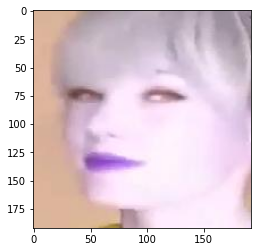

In [ ]:
plt.imshow(tmp_sample)
plt.show()

In [ ]:
# from testing sets
imagedecmp_tmp = ImageDecomposer(tmp_sample)
imagedecmp_tmp.plot_decmp_set()
imagedecmp_tmp.plot_diff_images()

NameError: ignored

== PLOT TK Panorama ===
PROCESSING/ .........................

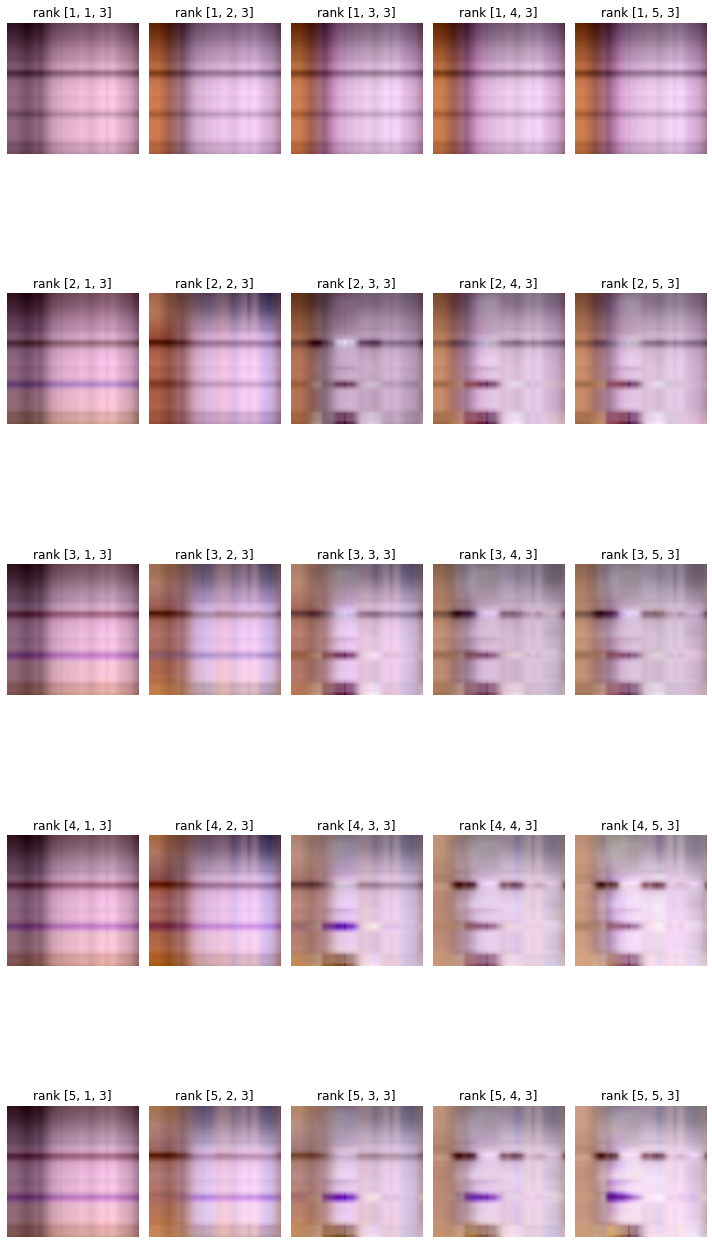

In [ ]:
imagedecmp_tmp.plot_TK_panorama()

### Test Real and Fake Samples Together

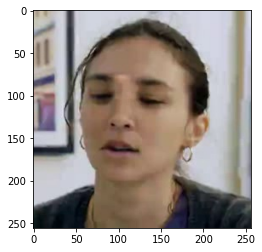

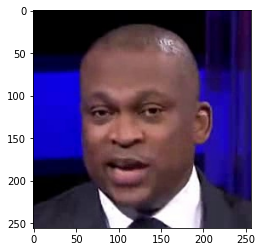

In [ ]:
fake_sample = cv2.imread(os.path.join(fakedir, fakefiles[0]))# np.random.choice(fakefiles, 1)[0]))
real_sample = cv2.imread(os.path.join(realdir, realfiles[0]))# np.random.choice(realfiles, 1)[0]))

b, g, r = cv2.split(fake_sample)
fake_sample = cv2.merge([r, g, b])

b, g, r = cv2.split(real_sample)
real_sample = cv2.merge([r, g, b])

plt.imshow(fake_sample)
plt.show()

plt.imshow(real_sample)
plt.show()

Process Evaluation

In [ ]:
imagedecmp_fake = ImageDecomposer(fake_sample)

==INIT IMAGEDECOMPOSER==
DONE


== PLOT DECOMPOSED TENSORS ===


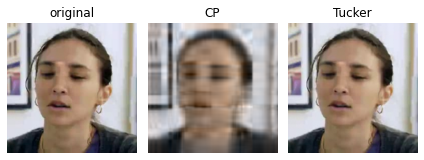

==PRINT IMAGE INFO : original==
shape:  (256, 256, 3)
mean:  142.86528523763022
max:  255
min:  0
std:  66.43506865268694
==PRINT IMAGE INFO : CP==
shape:  (256, 256, 3)
mean:  136.3756561279297
max:  255
min:  0
std:  54.860206929138165
==PRINT IMAGE INFO : Tucker==
shape:  (256, 256, 3)
mean:  146.46885681152344
max:  255
min:  0
std:  65.00291222373043
=== PLOT DIFF IMAGES & TENSORS ===


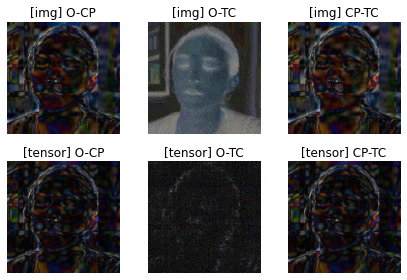

==PRINT IMAGE INFO : [img] O-CP==
shape:  (256, 256, 3)
mean:  0.13022465006510422
max:  1.0
min:  0.0
std:  0.1004048696336504
==PRINT IMAGE INFO : [img] O-TC==
shape:  (256, 256, 3)
mean:  0.27746855906951123
max:  1.0
min:  0.0
std:  0.1291705274724085
==PRINT IMAGE INFO : [img] CP-TC==
shape:  (256, 256, 3)
mean:  0.14231885381105563
max:  1.0
min:  0.0
std:  0.10583535240298407
==PRINT IMAGE INFO : [tensor] O-CP==
shape:  (256, 256, 3)
mean:  0.09164787978722304
max:  1.0
min:  0.0
std:  0.08624371586357485
==PRINT IMAGE INFO : [tensor] O-TC==
shape:  (256, 256, 3)
mean:  0.08390363057454427
max:  1.0
min:  0.0
std:  0.0828120653698456
==PRINT IMAGE INFO : [tensor] CP-TC==
shape:  (256, 256, 3)
mean:  0.09153537649326221
max:  1.0
min:  0.0
std:  0.08609810824996912


In [ ]:
imagedecmp_fake.plot_decmp_set()
imagedecmp_fake.plot_diff_images()

== PLOT CP Panorama ===
PROCESSING/ .........................

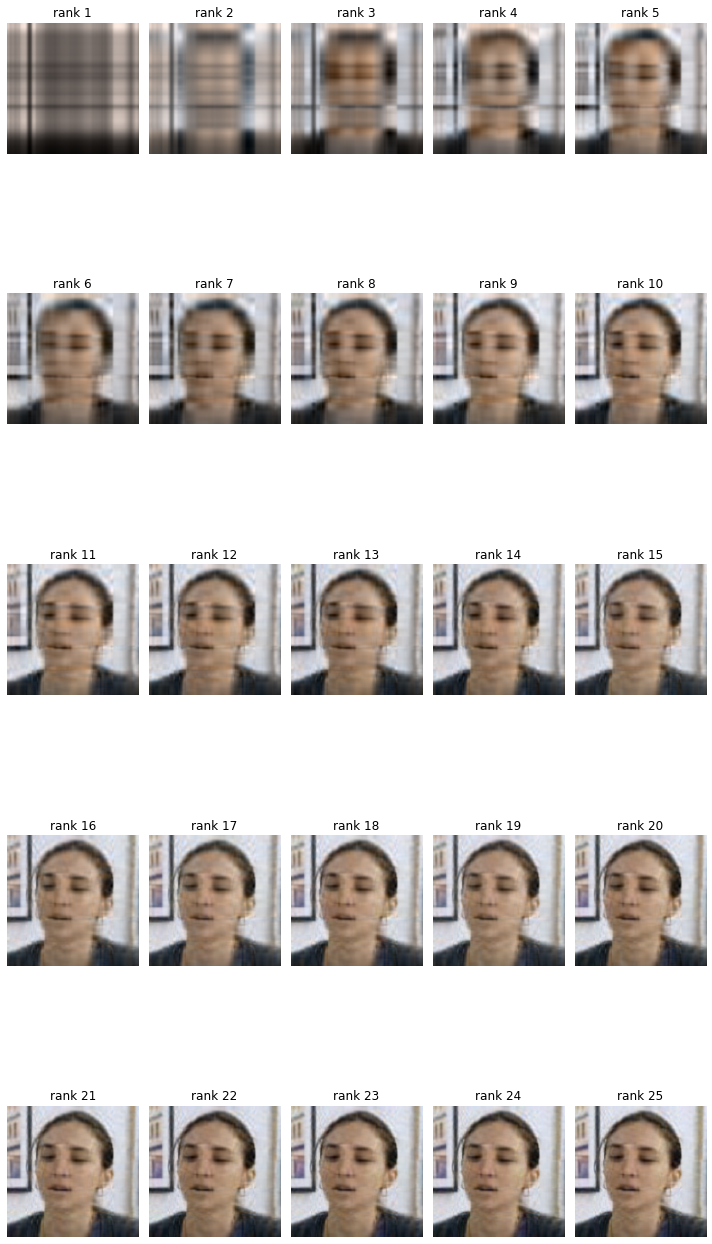

In [ ]:
imagedecmp_fake.plot_CP_panorama()

== PLOT TK Panorama ===
PROCESSING/ .........................

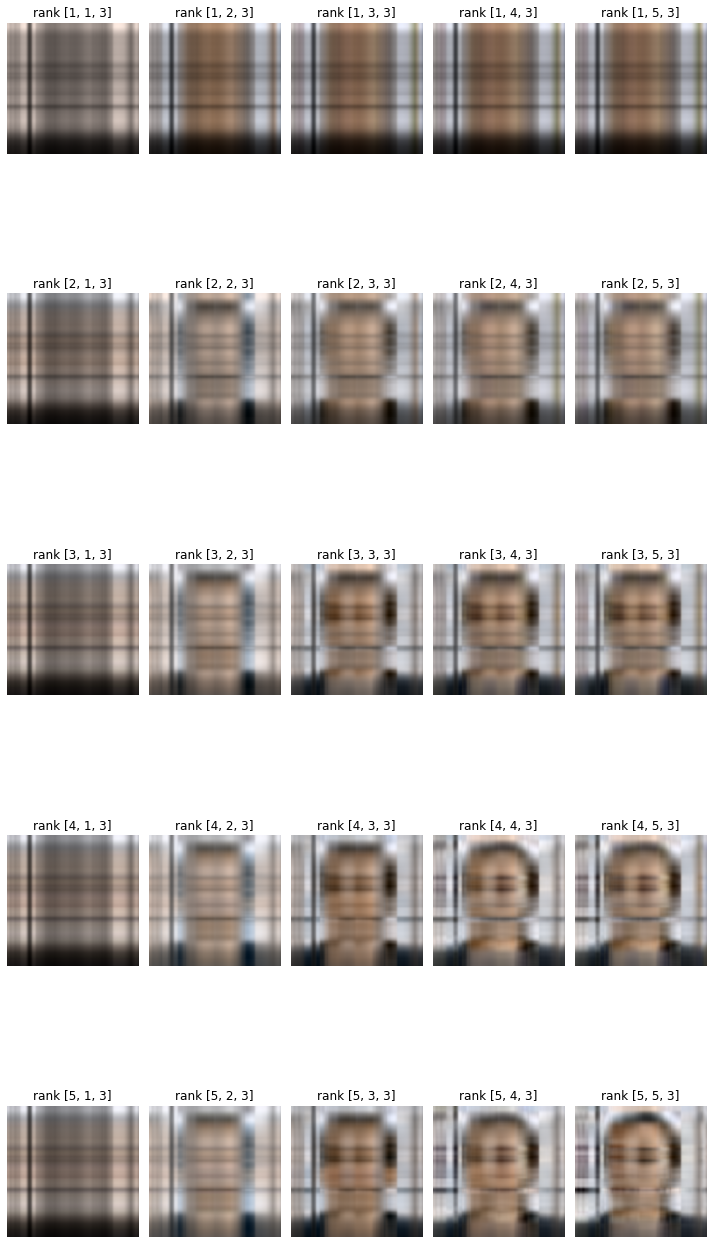

In [ ]:
imagedecmp_fake.plot_TK_panorama()

In [ ]:
imagedecmp_real = ImageDecomposer(real_sample)

==INIT IMAGEDECOMPOSER==
DONE


== PLOT DECOMPOSED TENSORS ===


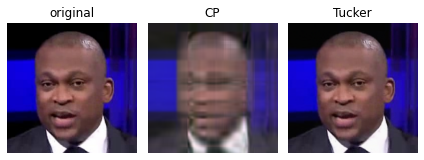

==PRINT IMAGE INFO : original==
shape:  (256, 256, 3)
mean:  68.86036682128906
max:  255
min:  0
std:  64.62956404271787
==PRINT IMAGE INFO : CP==
shape:  (256, 256, 3)
mean:  79.55806986490886
max:  255
min:  0
std:  45.23747116591668
==PRINT IMAGE INFO : Tucker==
shape:  (256, 256, 3)
mean:  70.52141825358073
max:  255
min:  0
std:  62.31774769268288
=== PLOT DIFF IMAGES & TENSORS ===


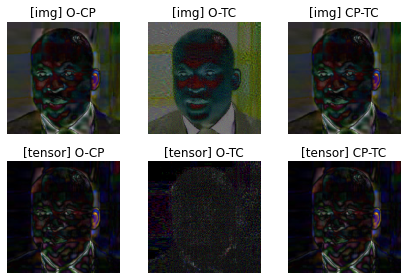

==PRINT IMAGE INFO : [img] O-CP==
shape:  (256, 256, 3)
mean:  0.1448903814092413
max:  1.0
min:  0.0
std:  0.09822351548605951
==PRINT IMAGE INFO : [img] O-TC==
shape:  (256, 256, 3)
mean:  0.2290778882575757
max:  1.0
min:  0.0
std:  0.13588971007127082
==PRINT IMAGE INFO : [img] CP-TC==
shape:  (256, 256, 3)
mean:  0.1347388325722564
max:  1.0
min:  0.0
std:  0.09481921967271924
==PRINT IMAGE INFO : [tensor] O-CP==
shape:  (256, 256, 3)
mean:  0.06578132236830607
max:  1.0
min:  0.0
std:  0.08424438151875732
==PRINT IMAGE INFO : [tensor] O-TC==
shape:  (256, 256, 3)
mean:  0.07870556059337795
max:  1.0
min:  0.0
std:  0.0887995078111152
==PRINT IMAGE INFO : [tensor] CP-TC==
shape:  (256, 256, 3)
mean:  0.06650195478582056
max:  1.0
min:  0.0
std:  0.0853227915019062


In [ ]:
imagedecmp_real.plot_decmp_set()
imagedecmp_real.plot_diff_images()

== PLOT CP Panorama ===
PROCESSING/ .........................

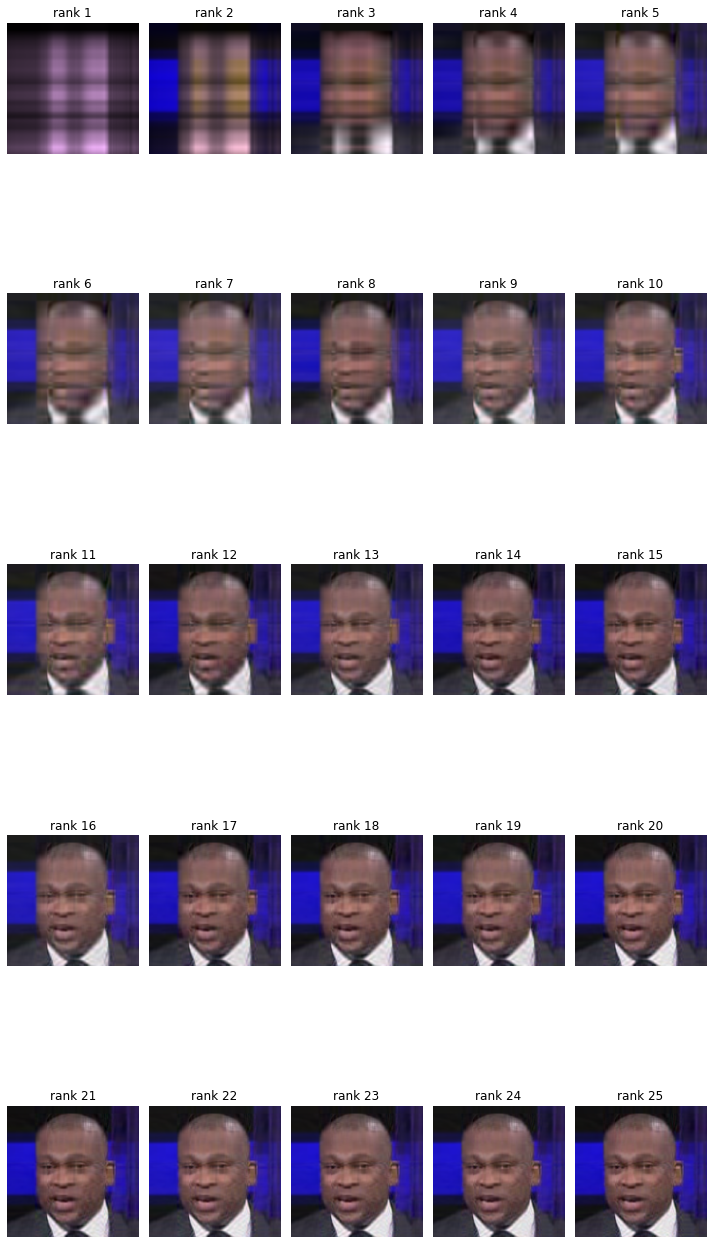

== PLOT TK Panorama ===
PROCESSING/ .........................

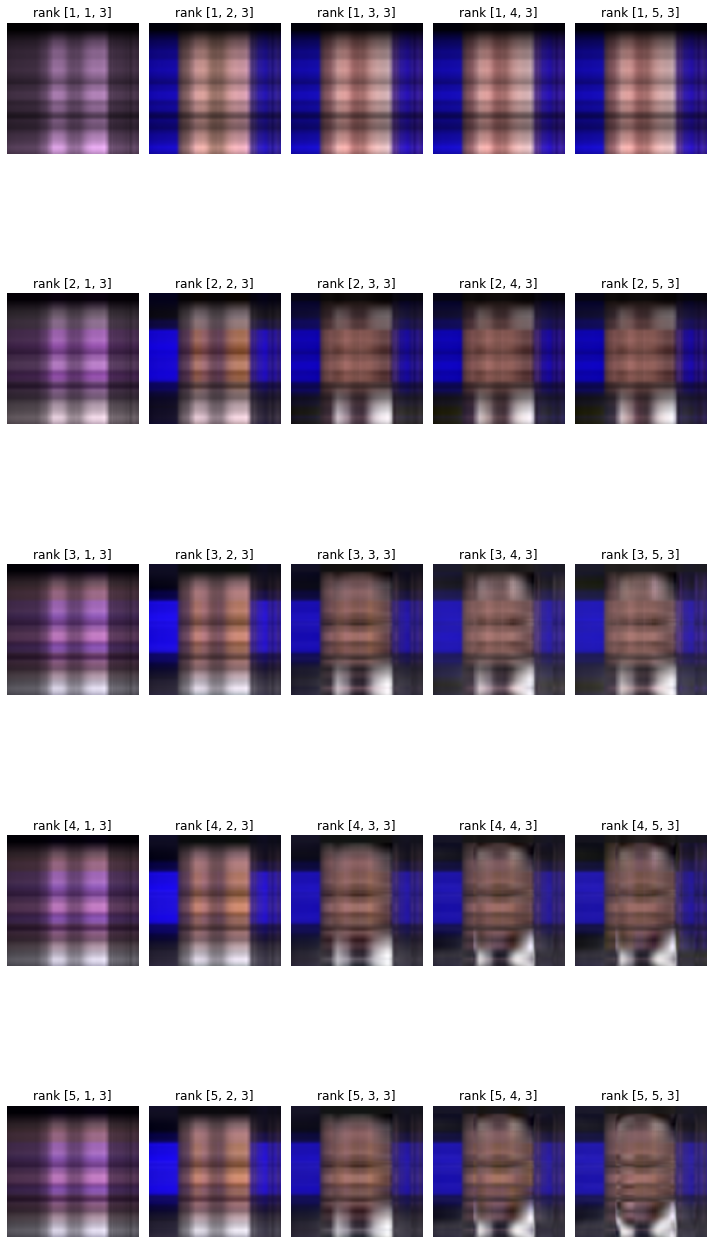

In [ ]:
imagedecmp_real.plot_CP_panorama()
imagedecmp_real.plot_TK_panorama()

## Analyze Dataset

In [ ]:
# testing
path = "/content/drive/My Drive/Colab Notebooks/RealFake/data"

fakedir = os.path.join(path, "train", "FAKE")
realdir = os.path.join(path, "train", "REAL")

#fakefiles = [f for f in os.listdir(fakedir)]
#realfiles = [f for f in os.listdir(realdir)]

In [ ]:
class DirStatsGenerator():
  def __init__(self):
    self.og = []
    self.cp = []
    self.tk = []
    self.cp_og = []
    self.tk_og = []
    self.cp_tk = []

  def flow_from_dir(self, dir):
    files = sorted(glob.glob(os.path.join(dir, "*.jpg")))
    cp_rank = 8
    tk_rank = [25, 25, 3]

    print("===ANALYZE FILES FROM {} ===".format(dir))
    print("cp_rank = ", cp_rank)
    print("tk_rank = ", tk_rank)
    print("PROCESSING")
    
    count = 0
    for file in files:
      
      # log the process
      count += 1
      print(".", end = "")
      if count % 100 == 0:
        print("") # new line
      
      # preprocess
      ogimg = cv2.imread(file)
      b, g, r = cv2.split(ogimg)
      ogimg = cv2.merge([r, g, b])
      og = self.to_tensor(ogimg)
      cp = self.to_CP(og, cp_rank)
      tk = self.to_TK(og, tk_rank)
      cpimg = self.to_image(cp)
      tkimg = self.to_image(tk)
      cp_og_img = self.get_diff_image(cpimg, ogimg)
      tk_og_img = self.get_diff_image(tkimg, ogimg)
      cp_tk_img = self.get_diff_image(cpimg, tkimg)

      # get means of each image
      ogimg = np.mean(ogimg)
      cpimg = np.mean(cpimg)
      tkimg = np.mean(tkimg)
      cp_og_img = np.mean(cp_og_img)
      tk_og_img = np.mean(tk_og_img)
      cp_tk_img = np.mean(cp_tk_img)

      # append
      self.og.append(ogimg)
      self.cp.append(cpimg)
      self.tk.append(tkimg)
      self.cp_og.append(cp_og_img)
      self.tk_og.append(tk_og_img)
      self.cp_tk.append(cp_tk_img)

      if count == 1000:
        break

    print("DESCRIBE STATS")
    self.describe_stats()
    print("")
    print("DONE")


  def plot_histogram(self, arr, bins):
    print("mean: ", np.mean(arr))
    print("var: ", np.var(arr))
    plt.hist(arr, bins = bins)
    plt.xlabel("AVERAGE PIXEL VALUE")
    plt.ylabel("")
    plt.show()

  def describe_stats(self):
    bins = 100
    self.plot_histogram(self.og, bins)
    self.plot_histogram(self.cp, bins)
    self.plot_histogram(self.tk, bins)
    self.plot_histogram(self.cp_og, bins)
    self.plot_histogram(self.tk_og, bins)
    self.plot_histogram(self.cp_tk, bins)

  # original image to tensor  
  def to_tensor(self, image):
    return tl.tensor(zoom(image, (1, 1, 1)), dtype='float64')
  
  # tensor to image
  def to_image(self, tensor):
    im = tl.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)

  # get image difference
  def get_diff_image(self, image1, image2):
    output = lambda x: (x - np.min(x)) / np.max(x) # normalize
    x = np.abs(image1.astype(np.int)-image2.astype(np.int))
    return output(x)

  # tensor decomposition using CP 
  def to_CP(self, tensor, r = 8):
    # Rank of the CP decomposition
    cp_rank = r
    # Perform the CP decomposition
    weights, factors = parafac(tensor, rank=cp_rank, init='random', tol=10e-6)
    # Reconstruct the image from the factors
    cp_reconstruction = tl.kruskal_to_tensor((weights, factors)) 
    return cp_reconstruction

  # tensor decomposition using TK
  def to_TK(self, tensor, r = [25, 25, 3]):
    # Rank of the Tucker decomposition
    tucker_rank = r
    random_state = 42
    # Tucker decomposition
    core, tucker_factors = tucker(tensor, ranks=tucker_rank, init='random', tol=10e-5, random_state=random_state)
    tucker_reconstruction = tl.tucker_to_tensor((core, tucker_factors))
    return tucker_reconstruction

===ANALYZE FILES FROM /content/drive/My Drive/Colab Notebooks/RealFake/data/train/FAKE ===
cp_rank =  8
tk_rank =  [25, 25, 3]
PROCESSING
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................

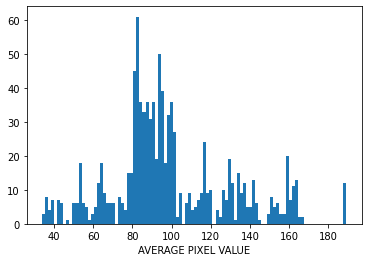

mean:  109.61847005716959
var:  580.5639318191866


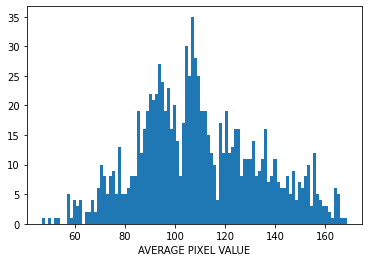

mean:  108.18499345906575
var:  693.3047471882159


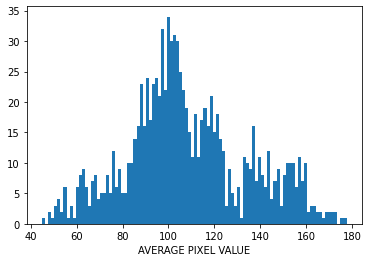

mean:  0.17696979464558274
var:  0.004648183977155732


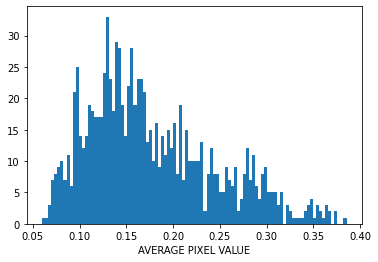

mean:  0.21889363043665327
var:  0.01054577211064038


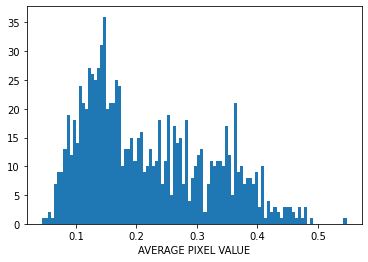

mean:  0.1261014092191609
var:  0.001195035096996148


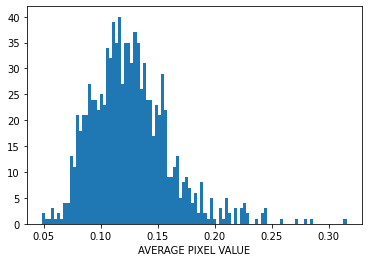


DONE


In [ ]:
fakedirstats = DirStatsGenerator()
with tf.device('/device:GPU:0'):
  fakedirstats.flow_from_dir(fakedir)

===ANALYZE FILES FROM /content/drive/My Drive/Colab Notebooks/RealFake/data/train/REAL ===
cp_rank =  8
tk_rank =  [25, 25, 3]
PROCESSING
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................

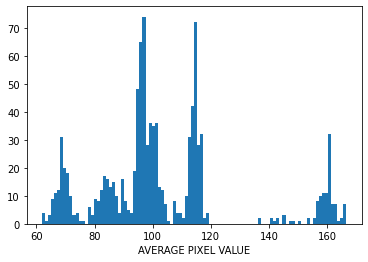

mean:  107.896676071167
var:  366.1391337514495


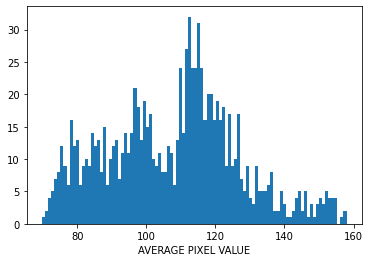

mean:  106.81529231262208
var:  462.24765629190193


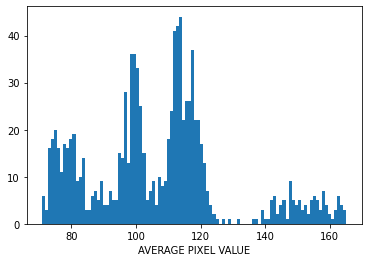

mean:  0.15175669932865588
var:  0.0013445038955900756


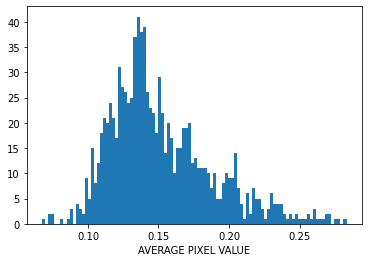

mean:  0.1740836376111152
var:  0.00621755442539147


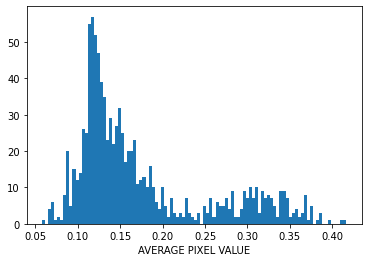

mean:  0.1270396771360469
var:  0.0010320910488293613


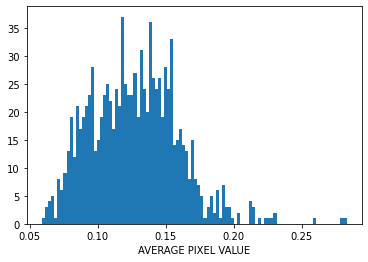


DONE


In [ ]:
realdirstats = DirStatsGenerator()
with tf.device('/device:GPU:0'):
  realdirstats.flow_from_dir(realdir)